# SARIMA mode
Feb 24th 2022

In [1]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm #help us to select p,d,q
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series_forecasting/time_series_analysis/week_3/2_arima_sarima_models


In [2]:
# Custom functions:
from src.timeseriesFunctions import get_years
import src.colorsetup

## Data Preparation and EDA

In [3]:
data= "./course_data/"
monthly_temp= pd.read_csv(data+"mean-monthly-temperature-1907-19.csv", 
                          names= ["month", "temp"], skipfooter= 2, engine= 'python',
                          infer_datetime_format= True, header= 0, index_col= 0)
monthly_temp.index= pd.to_datetime(monthly_temp.index)
# 'A'= annually
annual_temp=  monthly_temp.resample('A').mean()
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


In [4]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


In [5]:
get_years(monthly_temp)

Number of unique years: 66

['1907' '1908' '1909' '1910' '1911' '1912' '1913' '1914' '1915' '1916'
 '1917' '1918' '1919' '1920' '1921' '1922' '1923' '1924' '1925' '1926'
 '1927' '1928' '1929' '1930' '1931' '1932' '1933' '1934' '1935' '1936'
 '1937' '1938' '1939' '1940' '1941' '1942' '1943' '1944' '1945' '1946'
 '1947' '1948' '1949' '1950' '1951' '1952' '1953' '1954' '1955' '1956'
 '1957' '1958' '1959' '1960' '1961' '1962' '1963' '1964' '1965' '1966'
 '1967' '1968' '1969' '1970' '1971' '1972']


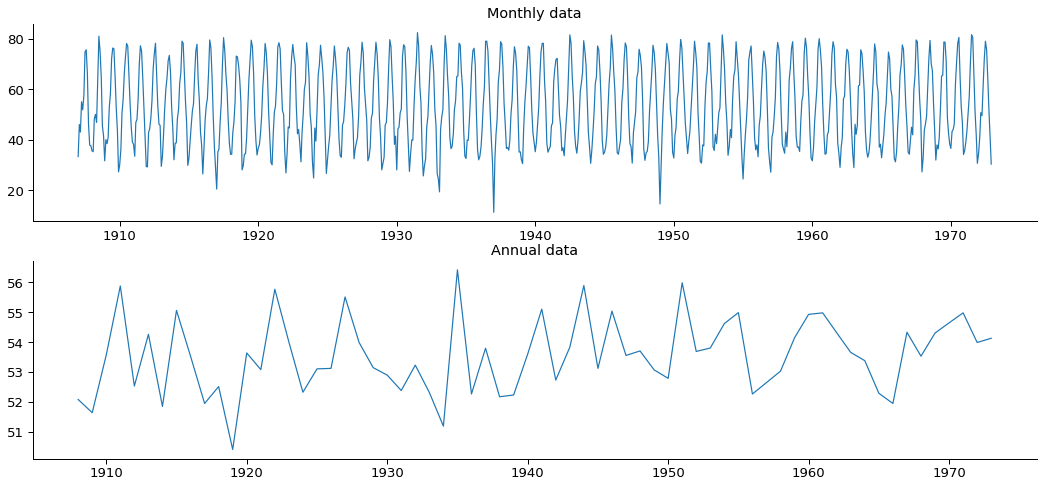

In [6]:
# Plot the temperature per year
fig, axes = plt.subplots(2,1, figsize= (18, 8))

axes[0].plot(monthly_temp)
axes[0].set_title("Monthly data")
axes[1].plot(annual_temp)
axes[1].set_title("Annual data")

plt.show()

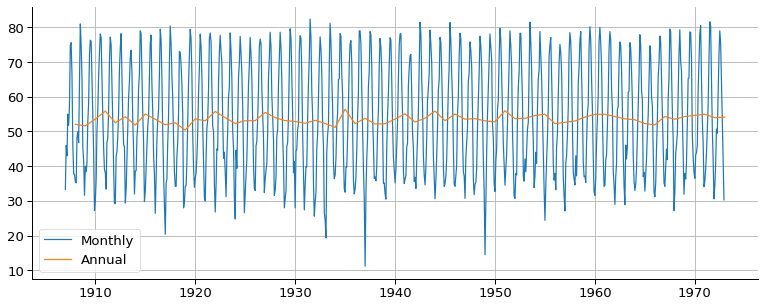

In [7]:
plt.plot(monthly_temp, label= "Monthly")
plt.plot(annual_temp, label= "Annual")
plt.legend()
plt.grid()
plt.show()

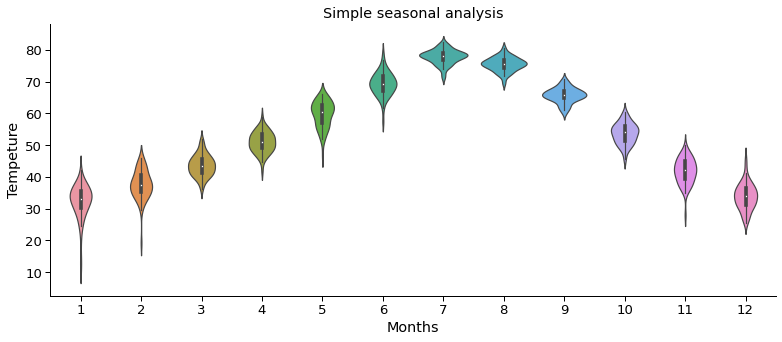

In [8]:
image_folder= "../../../plots/time_series_analysis/"
plot_name= "seasonal.analysis.png"

violin_plot= sns.violinplot(x= monthly_temp.index.month, y= monthly_temp.temp)
violin_plot.set_xlabel("Months")
violin_plot.set_ylabel("Tempeture")
violin_plot.set_title("Simple seasonal analysis")
fig= violin_plot.get_figure()
fig.savefig(image_folder+plot_name, transparent= True, bbox_inches= 'tight')

In [9]:
# Differencing by season:
monthly_temp['lag_12']= monthly_temp.shift(12)
display(monthly_temp.head(14))
monthly_temp['seasonal_diff']= monthly_temp.temp - monthly_temp.lag_12
display(monthly_temp.head(14))
# Log transformation for differencing by season
monthly_temp['seasonal_diff_log']= np.log10(np.array(monthly_temp.seasonal_diff) + monthly_temp.seasonal_diff.max())
display(monthly_temp.head(14))

,temp,lag_12
month,,
1907-01-01,33.3,NaN
1907-02-01,46.0,NaN
1907-03-01,43.0,NaN
1907-04-01,55.0,NaN
1907-05-01,51.8,NaN
1907-06-01,57.5,NaN
1907-07-01,74.8,NaN
1907-08-01,75.6,NaN
1907-09-01,66.3,NaN


,temp,lag_12,seasonal_diff
month,,,
1907-01-01,33.3,NaN,NaN
1907-02-01,46.0,NaN,NaN
1907-03-01,43.0,NaN,NaN
1907-04-01,55.0,NaN,NaN
1907-05-01,51.8,NaN,NaN
1907-06-01,57.5,NaN,NaN
1907-07-01,74.8,NaN,NaN
1907-08-01,75.6,NaN,NaN
1907-09-01,66.3,NaN,NaN


,temp,lag_12,seasonal_diff,seasonal_diff_log
month,,,,
1907-01-01,33.3,NaN,NaN,NaN
1907-02-01,46.0,NaN,NaN,NaN
1907-03-01,43.0,NaN,NaN,NaN
1907-04-01,55.0,NaN,NaN,NaN
1907-05-01,51.8,NaN,NaN,NaN
1907-06-01,57.5,NaN,NaN,NaN
1907-07-01,74.8,NaN,NaN,NaN
1907-08-01,75.6,NaN,NaN,NaN
1907-09-01,66.3,NaN,NaN,NaN


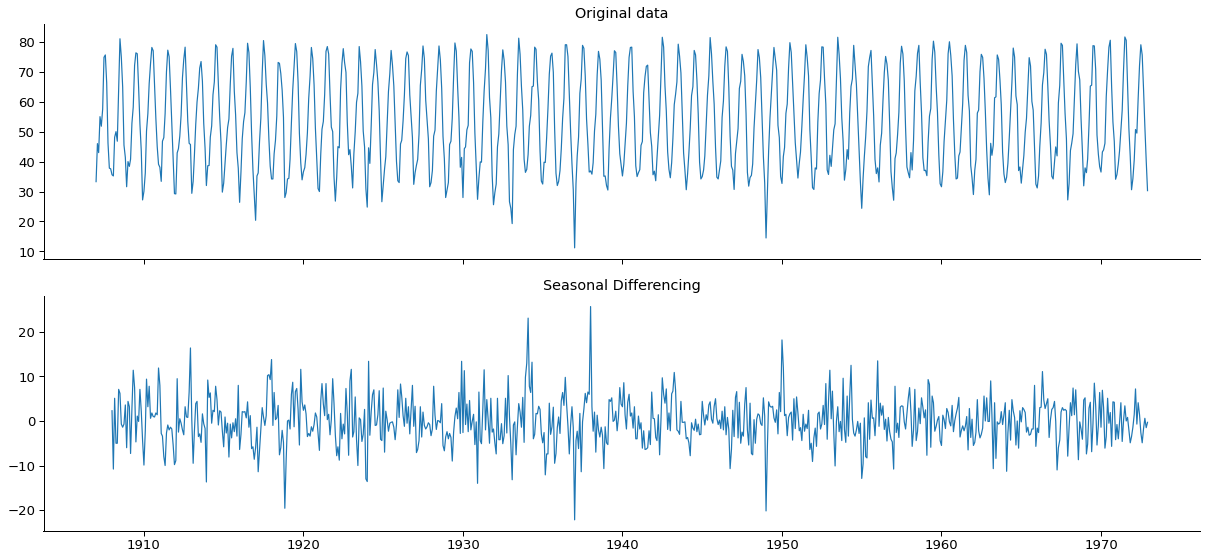

In [10]:
plot_name= "seasonal.differencing.png"

fig, axes = plt.subplots(2,1, figsize= (17,8), sharex= True)

axes[0].plot(monthly_temp.temp)
axes[0].set_title("Original data")

axes[1].plot(monthly_temp.seasonal_diff)
axes[1].set_title("Seasonal Differencing")

# axes[2].plot(monthly_temp.seasonal_diff_log)
# axes[2].set_title("Log10(Seasonal Differencing+25)")

plt.tight_layout()
plt.savefig(image_folder+plot_name, transparent= True)
plt.show()

In [11]:
def dickey_fuller_test(timeseries):
    """
    NUll hypothesis= time-series is not stationary
    """
    test= adfuller(timeseries)
    df= pd.Series(test[0:4], index= ["Test-statistics", "p-value", "Lags-used", "Observation-used"])
    for key,value in test[4].items():
        df['Critical value (%s)'%key] = value    
    print(df)
    # Rolling
    rolmean= timeseries.rolling(window=12).mean()
    rolstd= timeseries.rolling(window=12).std()
    # Plotting
    original= plt.plot(timeseries, color= "blue", label= "Original Time-series")
    mean= plt.plot(rolmean, color= "red", label= "Rolling Mean")
    std= plt.plot(rolstd, color= "black", label= "Rolling Std")
    plt.legend(loc= "best")
    plt.grid()
    plt.show()

Test-statistics        -6.481466e+00
p-value                 1.291867e-08
Lags-used               2.100000e+01
Observation-used        7.700000e+02
Critical value (1%)    -3.438871e+00
Critical value (5%)    -2.865301e+00
Critical value (10%)   -2.568773e+00
dtype: float64


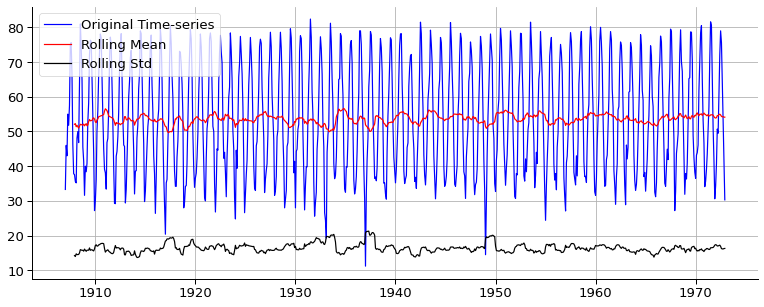

In [12]:
dickey_fuller_test(monthly_temp.temp)

Test-statistics        -7.878242e+00
p-value                 4.779473e-12
Lags-used               0.000000e+00
Observation-used        6.500000e+01
Critical value (1%)    -3.535217e+00
Critical value (5%)    -2.907154e+00
Critical value (10%)   -2.591103e+00
dtype: float64


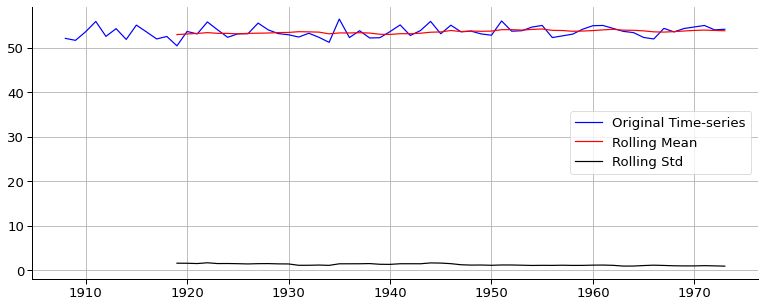

In [13]:
dickey_fuller_test(annual_temp.temp)

## SARIMA with Statsmodels

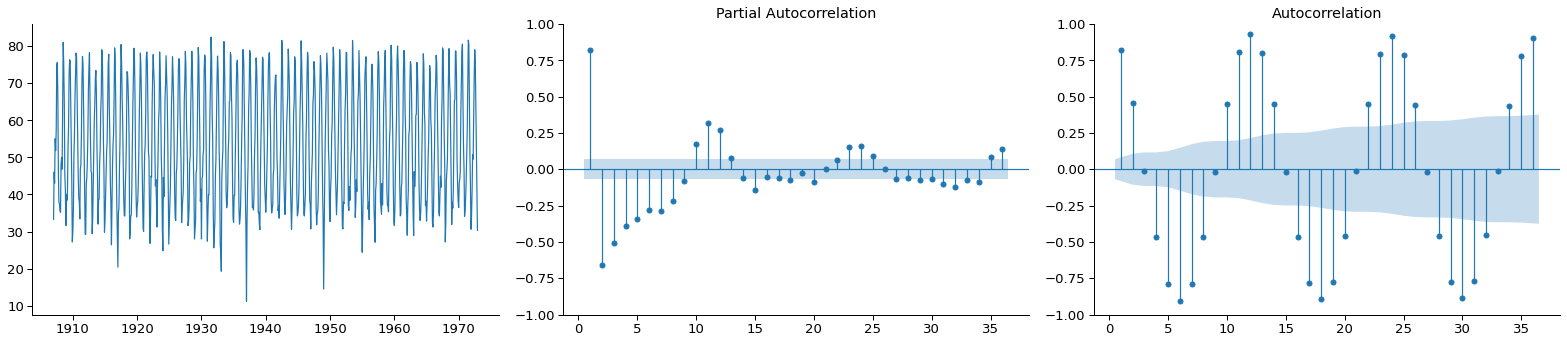

In [14]:
def eda_plots(data, lags= None, save= False, save_path= ''):
    plt.rcParams['figure.figsize']= (22,5)
    layout= (1,3)
    raw= plt.subplot2grid(layout, (0,0))
    pacf= plt.subplot2grid(layout, (0,1))
    acf= plt.subplot2grid(layout, (0,2))
    
    raw.plot(data)
    plot_acf(data, lags= lags, ax= acf, zero= False)
    plot_pacf(data, lags= lags, ax= pacf, zero= False)
    plt.tight_layout()
    if save:
        plt.savefig(save_path, transparent= True)

plot_name= 'eda.pacf.acf.png'        
eda_plots(monthly_temp.temp, lags= 36, save= True, save_path= image_folder+plot_name)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

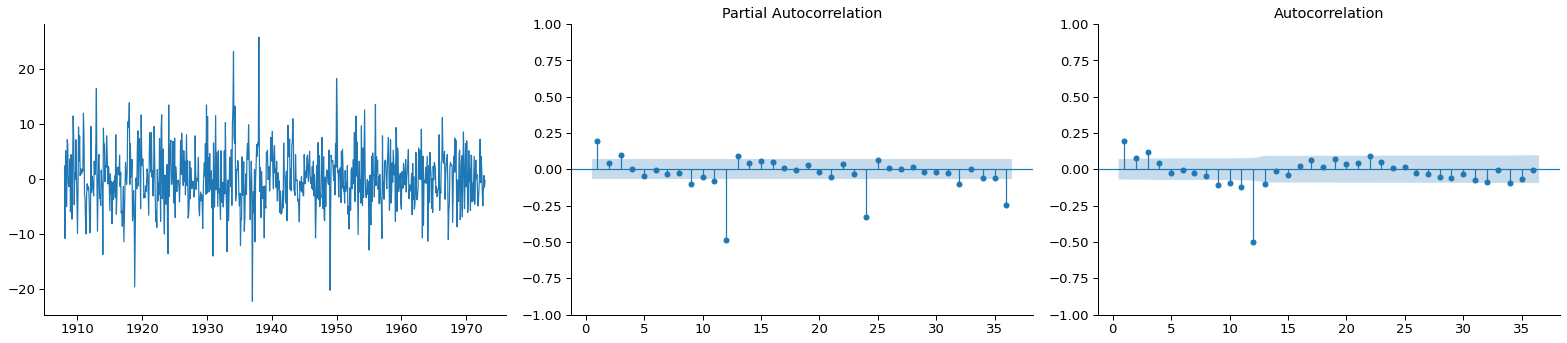

In [15]:
plot_name= "eda.differencing.pacf.acf.png"
eda_plots(monthly_temp.seasonal_diff.dropna(), lags= 36, save= True, save_path= image_folder+plot_name)

In [16]:
# 1) seasonal_order= P,D,Q,s; s= periodicity. s= 12 ==> monthly data 
# 2) trend= 'c'; means constant trend
sar= SARIMAX(monthly_temp.temp, order= (1,0,0), seasonal_order= (0,1,1,12), trend= 'c').fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79583D+00    |proj g|=  8.54150D-02

At iterate    5    f=  2.70074D+00    |proj g|=  2.46650D-02

At iterate   10    f=  2.68921D+00    |proj g|=  2.48174D-02

At iterate   15    f=  2.68806D+00    |proj g|=  4.35172D-03

At iterate   20    f=  2.68798D+00    |proj g|=  4.97151D-03

At iterate   25    f=  2.68797D+00    |proj g|=  1.48048D-04

At iterate   30    f=  2.68797D+00    |proj g|=  1.38352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [17]:
# A|C and B|C, we want this values as low as possible. Measure the complexity of the model
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2128.873
Date:                              Fri, 04 Mar 2022   AIC                           4265.746
Time:                                      11:55:33   BIC                           4284.383
Sample:                                  01-01-1907   HQIC                          4272.914
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.007      1.698      0.090      -0.002       0.027
ar.L1          0.1791      0.035      5.105      0.000       0.110       0.248
ma.S.L12      -0.9995      1.055     -0.947      0.343      -3.068       1.069
sigma2        12.8937     13.487      0.956      0.339     -13.539      39.327
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               252.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.56
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

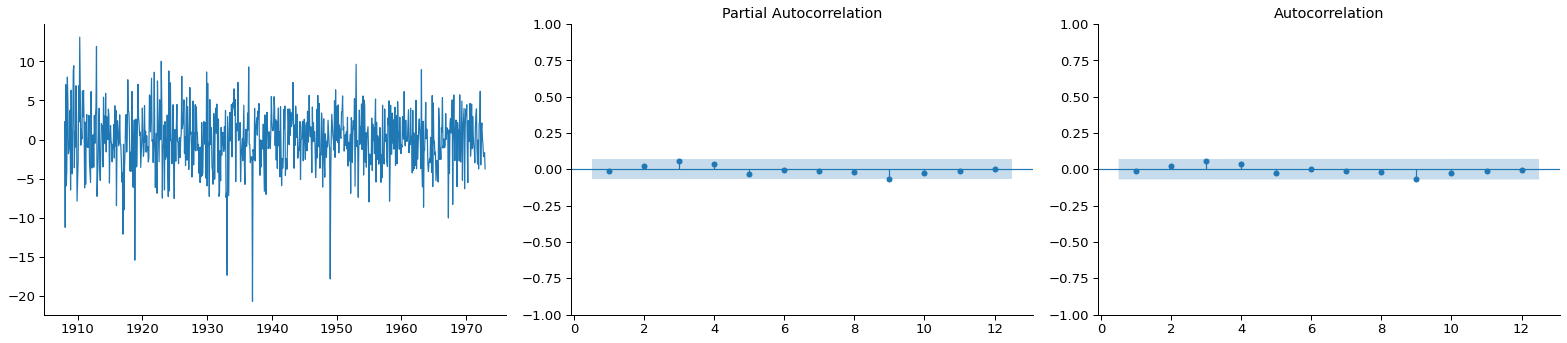

In [18]:
# Plot the residuals
plot_name= "eda.residuals.pacf.acf.png"
eda_plots(sar.resid[sar.loglikelihood_burn:], lags= 12, save= True, save_path= image_folder+plot_name)

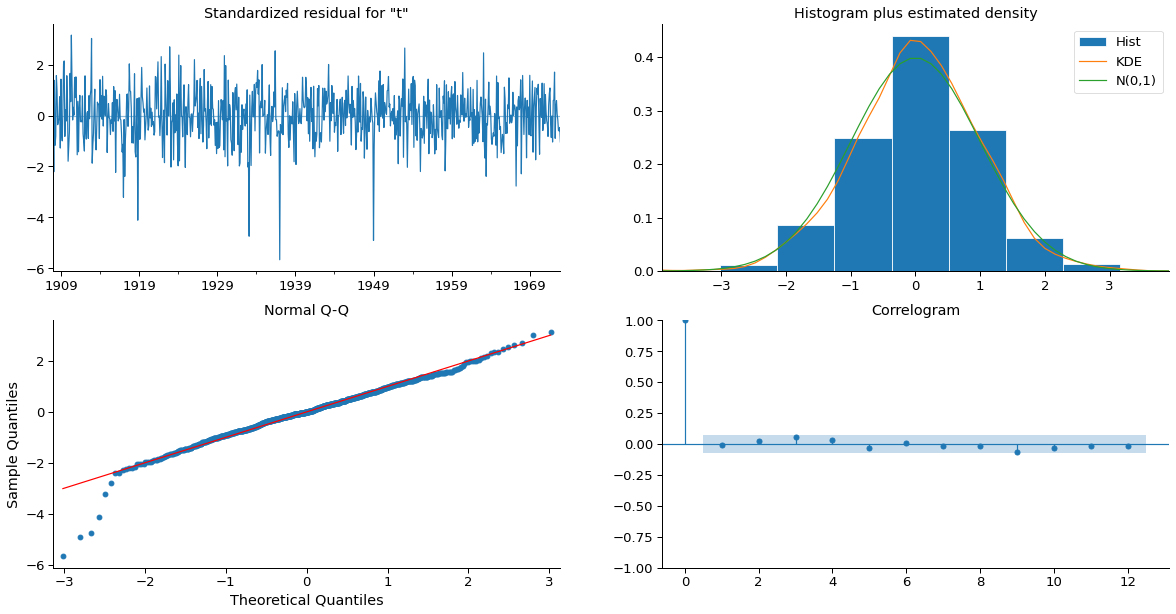

In [19]:
diagnostics= sar.plot_diagnostics(lags= 12, figsize= (20,10))

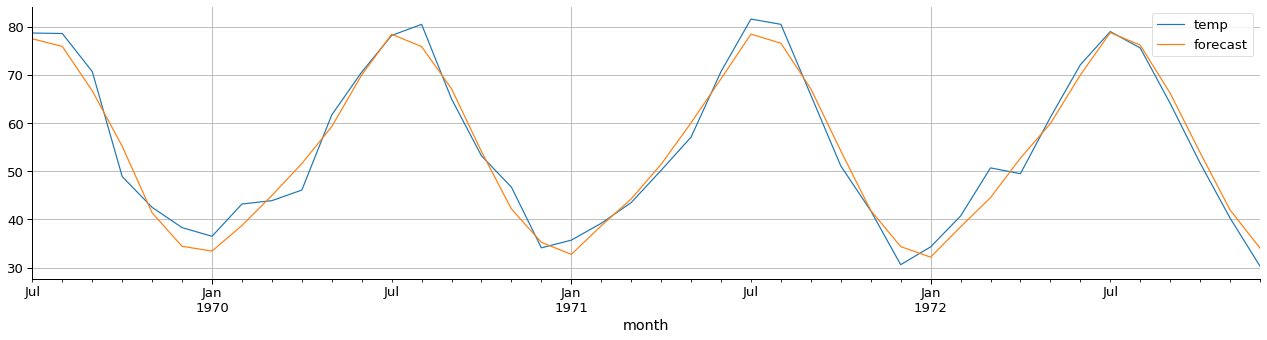

In [20]:
monthly_temp['forecast']= sar.predict(start= 750, end= 792)
# display(monthly_temp[['temp', 'forecast']])
# Plot
monthly_temp[750:][['temp', 'forecast']].plot()
plt.grid()
plt.show()

In [21]:
sar2= SARIMAX(monthly_temp.temp, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c').fit()
sar2.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79011D+00    |proj g|=  8.49400D-02

At iterate    5    f=  2.69882D+00    |proj g|=  2.04038D-02

At iterate   10    f=  2.68676D+00    |proj g|=  8.39738D-03

At iterate   15    f=  2.68570D+00    |proj g|=  1.03353D-02

At iterate   20    f=  2.68559D+00    |proj g|=  4.77539D-03

At iterate   25    f=  2.68557D+00    |proj g|=  7.39612D-04

At iterate   30    f=  2.68557D+00    |proj g|=  4.60790D-04

At iterate   35    f=  2.68557D+00    |proj g|=  2.34788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2126.970
Date:                              Fri, 04 Mar 2022   AIC                           4265.939
Time:                                      11:55:45   BIC                           4293.895
Sample:                                  01-01-1907   HQIC                          4276.691
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0114      0.008      1.510      0.131      -0.003       0.026
ar.L1          0.1711      0.036      4.742      0.000       0.100       0.242
ar.L2          0.0229      0.036      0.637      0.524      -0.048       0.093
ar.L3          0.0615      0.037      1.665      0.096      -0.011       0.134
ma.S.L12      -0.9998      2.098     -0.476      0.634      -5.113       3.113
sigma2        12.8270     26.794      0.479      0.632     -39.689      65.343
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               242.83
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

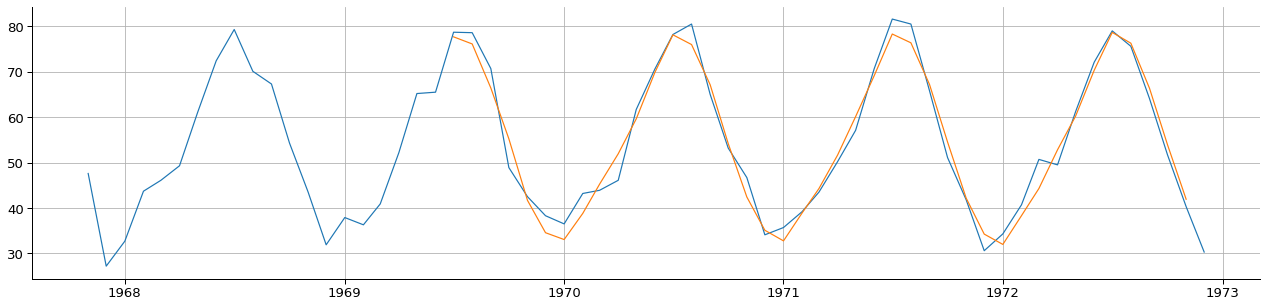

In [22]:
monthly_temp['forecast_2'] = sar2.predict(start = 750, end= 790, dynamic=False)  
plt.plot(monthly_temp[730:][['temp', 'forecast_2']])
plt.grid()

Future forecast

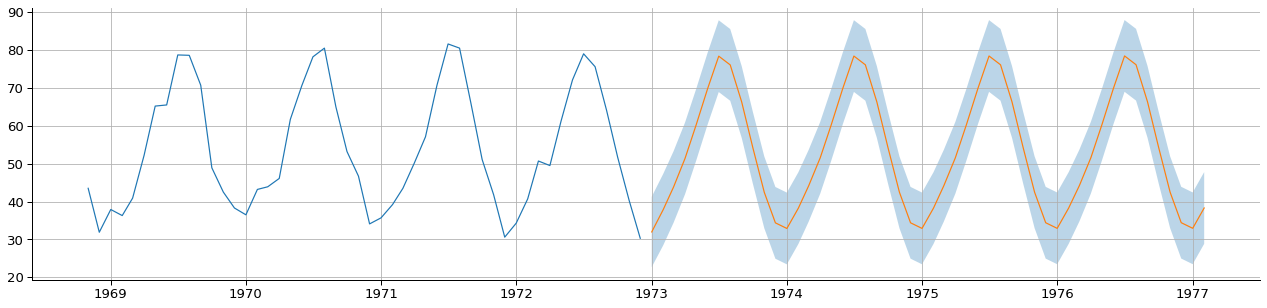

In [23]:
future_forecast= sar2.get_forecast(50)
confidence_int= future_forecast.conf_int(alpha= 0.01)
# Pull predicted mean
fcst= future_forecast.predicted_mean
# Plot
plt.plot(monthly_temp.temp[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index, confidence_int['lower temp'], confidence_int['upper temp'], alpha= 0.3)
plt.grid()
plt.show()

### Statistical tests:
* 1) Jarque-Bera => Normality. Null hypothesis= residuals are normally distributed
* 2) Ljung-Box => Serial correlaiton. Null hypothesis= is no serial correlation in residuals (independent of each other)
* 3) Heteroskedasticity => change in variance for residuals. Null hypothesis= is not heteroskedasticity
* 4) Durbin-Watson => Test autocorrelation of residuals. We want 1-3, 2 is ideal (no serial correlation)

In [24]:
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
lb_val = lb_val[-1]
lb_p = lb_p[-1]

durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p))
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p))
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p))
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=252.771, p=0.000
Ljung-Box: val=15.499, p=0.905
Heteroskedasticity: val=0.708, p=0.006
Durbin-Watson: d=2.01


## Autofit models

In [25]:
%%time
# m ==> The period for seasonal differencing, ``m`` refers to the number of periods in each season. For example, ``m`` is 12 for monthly data
stepwise_model = pm.auto_arima(monthly_temp.temp, 
                               start_p=0, max_p= 3,
                               d= 0, 
                               start_q=0, max_q= 3,
                               m=12, seasonal=True,
                               start_P=0, 
                               D=1, 
                               start_Q= 0,
                               trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print('')
print('-'*28)
print("A|C: {:.3f}\np,d,q: {}\nP,D,Q: {}".format(stepwise_model.aic(), stepwise_model.order, stepwise_model.seasonal_order)) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4796.839, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4546.179, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4794.867, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4769.737, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4451.142, Time=2.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.02 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4477.926, Time=2.04 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4452.084, Time=2.55 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4450.271, Time=3.29 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4545.537, Time=1.17 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=12.24 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.62 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=

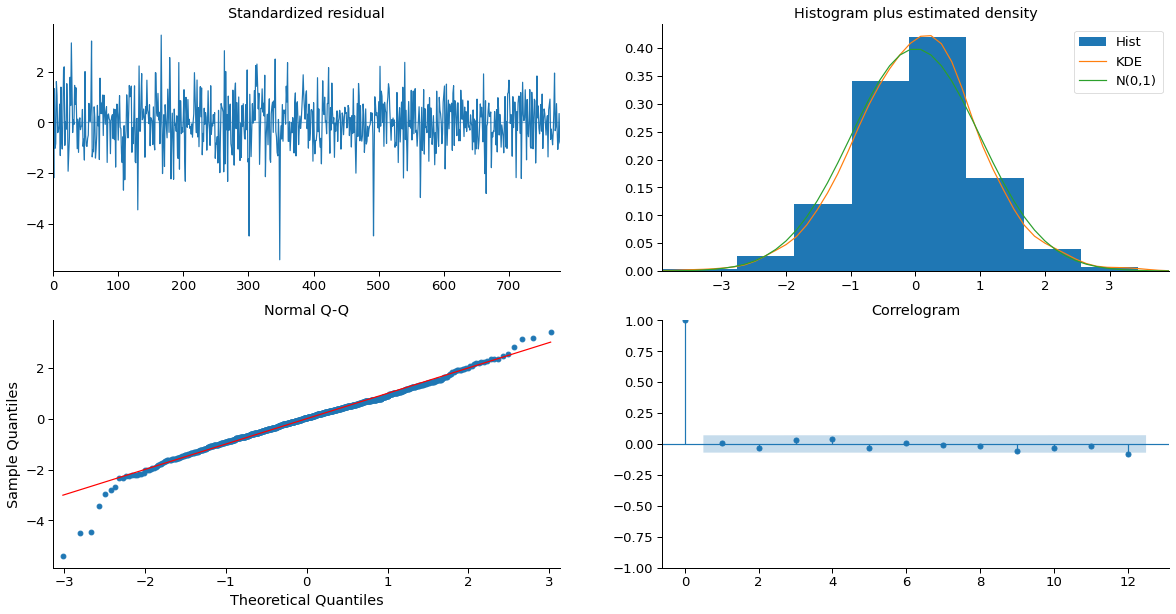

In [26]:
# diagnostics= sar.plot_diagnostics(lags= 12, figsize= (20,10))
stepwise_diag= stepwise_model.plot_diagnostics(lags=12, figsize= (20,10))

In [27]:
def future_preds_df(model,series,num_months):
    """
    Generate a df with model predictions
    """
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

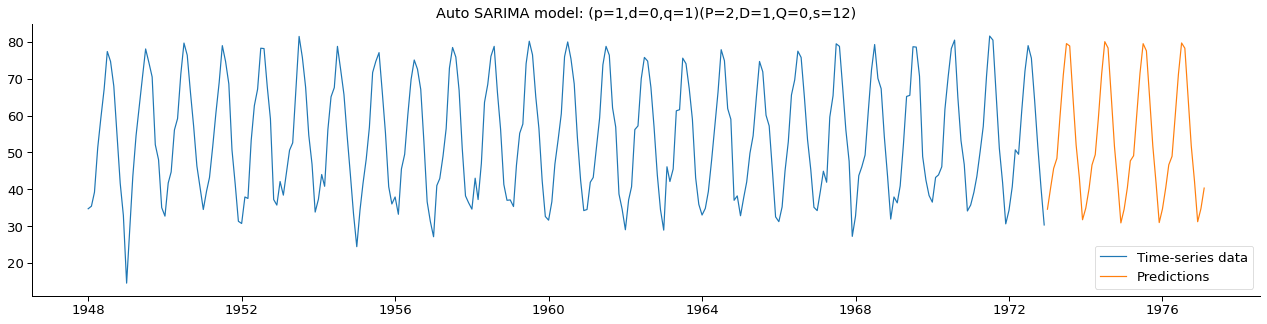

In [32]:
predictions= future_preds_df(stepwise_model, monthly_temp.temp, 50)

plot_name= 'sarima.predictions.png'
plt.plot(monthly_temp.temp[-300:], label= "Time-series data")
plt.plot(predictions, label= "Predictions")

plt.legend()
plt.title("Auto SARIMA model: (p=1,d=0,q=1)(P=2,D=1,Q=0,s=12)")
plt.savefig(image_folder+plot_name, transparent= True)
plt.show()

In [33]:
import session_info
session_info.show()